In [13]:
%load_ext autoreload
%autoreload 2
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import pandas as pd
from cuml.manifold.umap import UMAP as cumlUMAP
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms

### load data

In [15]:
DATASET_ID = 'BIRD_DB_Toxostoma_redivivum'
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'thrasher.pickle'

In [16]:
syllable_df = pd.read_pickle(df_loc)
del syllable_df['audio']

In [17]:
syllable_df[:3]

,start_time,end_time,labels,indv,indvi,subject_importance,key,rate,spectrogram
0,10.219057,10.650069,apa,CATH-TLR3,0,Primary subject,2012-02-10_10-10-00-000000,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,10.927989,11.403752,apa,CATH-TLR3,0,Primary subject,2012-02-10_10-10-00-000000,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,11.864023,11.901707,axk,CATH-TLR3,0,Primary subject,2012-02-10_10-10-00-000000,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [18]:
np.shape(syllable_df.spectrogram.values[0])

(32, 24)

In [19]:
indvs_sorted = pd.DataFrame(
    {i: [sum(syllable_df.indv == i)]
     for i in syllable_df.indv.unique()}).T.sort_values(
         by=0, ascending=False)[:10].T
indvs_sorted

,CATH-CP1,CATH-TLR8,CATH-TLR9,CATH-TLR1,CATH-TLR2,CATH-TLR7,CATH-TLR10,CATH-TLR12,CATH-TLR4,CATH-TLR3
0,2881,2618,1422,1404,1340,1092,701,670,664,621


### project

(2881, 768)


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  # This is added back by InteractiveShellApp.init_path()
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  if sys.path[0] == '':


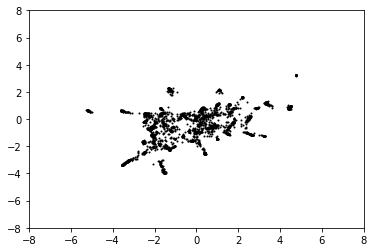

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(2618, 768)


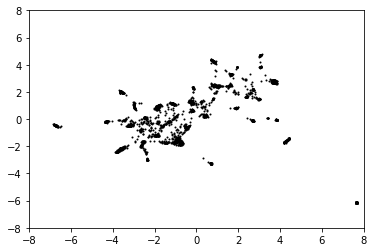

(1422, 768)


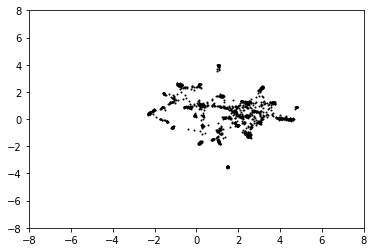

(1404, 768)


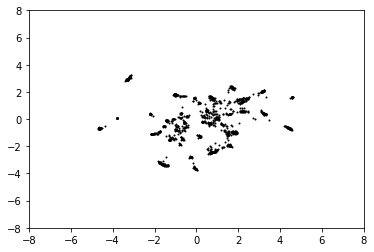

(1340, 768)


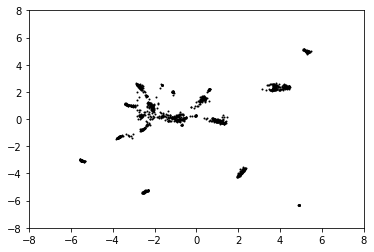

(1092, 768)


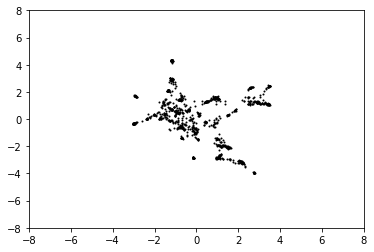

(701, 768)


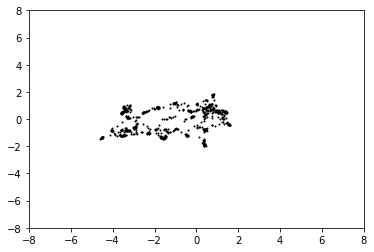

(670, 768)


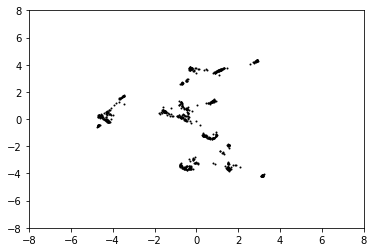

(664, 768)


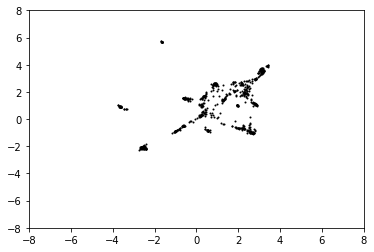

(621, 768)


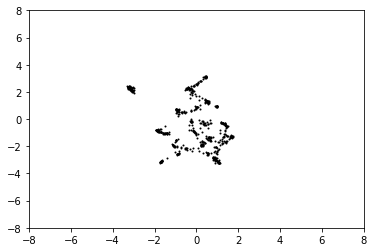

In [22]:
ensure_dir(DATA_DIR / 'embeddings' / DATASET_ID / 'full')

for indv in tqdm(list(indvs_sorted.columns)):
    subset_df = syllable_df[syllable_df.indv == indv]
    
    specs = list(subset_df.spectrogram.values)
    specs = [i/np.max(i) for i in tqdm(specs)]
    specs_flattened = flatten_spectrograms(specs)
    print(np.shape(specs_flattened))
    
    cuml_umap = cumlUMAP()
    embedding = cuml_umap.fit_transform(specs_flattened)
    
    fig, ax = plt.subplots()
    ax.scatter(embedding[:,0], embedding[:,1], s=1, color='k', alpha = 1)
    ax.set_xlim([-8,8])
    ax.set_ylim([-8,8])
    plt.show()
    
    subset_df['umap'] = list(embedding)
    subset_df.to_pickle(DATA_DIR / 'embeddings' / DATASET_ID / (indv + '.pickle'))